In [1]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torchvision
import cellpylib as cpl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Generation

In [27]:
def generate_pairs_1D_rand(num_samples, rule_number, ca_size):
    
    # Initialize dataset array
    input_data = torch.zeros((num_samples, 1, ca_size + 6))  
    output_data = torch.zeros((num_samples, 1, ca_size + 6))

    for t in range(num_samples):
        
        # create a random initial ca state
        ic = cpl.init_random(ca_size)[0]
        ca = np.array([np.concatenate((np.zeros(3), ic, np.zeros(3)))])
        
        # convert the ca state from 0s and 1s to -1s and 1s
        converted_ca = torch.where(torch.tensor(ca) == 0, -1, torch.tensor(ca))
        input_data[t][0] = converted_ca
        
        # evolve state for 1 time step based on update rule
        ca = cpl.evolve(ca, timesteps=2, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)
        
        # we want output data to be of 0s and 1s, because when we apply ReLu, negatives vanish
        output_data[t][0] = torch.tensor(ca[1])

    return input_data, output_data

In [5]:
def generate_all_states_1D(rule_number, ca_size):
        
        
    # create all possible configurations of 0s and 1s
    def generate_all_possible_binary_images(ca_size):
        if ca_size <= 0:
            return [[]]

        def backtrack(start, path, result):
            if len(path) == ca_size:
                result.append([path[:]])
                return

            for i in range(start, 2):
                path.append(i)
                backtrack(0, path, result)
                path.pop()

        result = []
        backtrack(0, [], result)        
        return result

    
    all_binary_images = generate_all_possible_binary_images(ca_size)
    input_data_np = np.array(all_binary_images)
    
    # randomize the order of the data
    np.random.shuffle(input_data_np)
    
    # evolve the data and set it as output data
    output_data_np = np.zeros((2**ca_size, 1, ca_size))
    for t in range(len(input_data_np)):
        state = np.array(input_data_np[t])
        state = cpl.evolve(state, timesteps=2, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)
        output_data_np[t][0] = state[1]
    
    
    #convert data from numpy arrays to pytorch tensors
    input_data = torch.from_numpy(input_data_np).to(torch.float32)
    output_data = torch.from_numpy(output_data_np).to(torch.float32)

    
    
    # convert the 0s from input data to -1s   
    input_data = torch.where(input_data == 0, -1, input_data)
    
    
    return input_data, output_data 


In [39]:
x_data, y_data = generate_pairs_1D_rand(num_samples=5000, rule_number=225, ca_size=150)

In [40]:
torch.save(x_data, 'C:\\Users\\windows\\Research\\CA_Project\\datasets\\1d_225_padded_casize150_input_data.pt')
torch.save(y_data, 'C:\\Users\\windows\\Research\\CA_Project\\datasets\\1d_225_padded_casize150_output_data.pt')

In [41]:
x_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\1d_225_padded_casize150_input_data.pt')
y_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\1d_225_padded_casize150_output_data.pt')

print("x_data", x_data.size())
print("y_data", y_data.size())

x_data torch.Size([5000, 1, 156])
y_data torch.Size([5000, 1, 156])


## Split Data Into Training Set and Test Set

In [42]:
split = int(0.80 * len(x_data))
print(split)
x_train = x_data[:split]
y_train = y_data[:split]
x_test = x_data[split:]
y_test = y_data[split:]

4000


In [43]:
batch_size = 8

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Build Neural Network

In [52]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=5, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=1)
        self.conv_final = nn.Conv1d(in_channels=5, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x
        
        # if I want to convert to binary numbers, then I can just do torch.round()
        # However, I should note that doing that here will destroy the gradient
        

In [53]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

print(model)

ConvNet(
  (conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(10, 5, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(5, 10, kernel_size=(1,), stride=(1,))
  (conv_final): Conv1d(5, 1, kernel_size=(1,), stride=(1,))
)


## Optimization Loop

In [54]:
n_epochs = 15
accuracies = np.zeros(n_epochs)

# step = 0
for epoch in range(n_epochs):
    
    print("\n-------------------------------")
    
    # train loop
    model.train()
    for batch, (inputs, outputs) in enumerate(train_loader):
        
        inputs, outputs = inputs.to(device), outputs.to(device)
        
        # compute predictions
        predictions = model(inputs)
        
        # calculate loss
        loss = loss_fn(predictions, outputs)
        
        #backpropogation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print progress
        # if (batch+1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/{n_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # writer.add_scalar("Training Loss", loss, global_step=step)
        # step += 1
        
            
    # test loop
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        
        for inputs, outputs in test_loader:
            
            inputs, outputs = inputs.to(device), outputs.to(device)
            
            predictions = model(inputs)
            loss = loss_fn(predictions, outputs)
            test_loss += loss.item()
                
            # correct += (torch.round(predictions) == outputs).sum().item()
            for i in range(len(predictions)):
                rounded_prediction = torch.round(predictions[i])
                if rounded_prediction.equal(outputs[i]):
                    correct += 1
            
    average_test_loss = test_loss / len(test_loader)
    total = len(test_loader.dataset)
    accuracy = correct / total
    accuracies[epoch] = accuracy
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Test Loss: {average_test_loss:.4f}, Test Accuracy: {accuracy:.2%}')
    print('correct:', correct)
    print('total:', total)
    

    
print('Training and Testing finished.')
    


-------------------------------
Epoch [1/15], Test Loss: 0.2319, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [2/15], Test Loss: 0.1414, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [3/15], Test Loss: 0.0978, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [4/15], Test Loss: 0.0710, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [5/15], Test Loss: 0.0530, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [6/15], Test Loss: 0.0002, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [7/15], Test Loss: 0.0000, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [8/15], Test Loss: 0.0000, Test Accuracy: 100.00%
correct: 1000
total: 1000

-------------------------------
Epoch [9/15], Test Loss: 0.0000, Test Accuracy:

In [55]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': n_epochs
}

# Specify the file path where you want to save the model
save_path = 'C:\\Users\\windows\\Research\\CA_Project\\pytorch_stuff\\models\\CNN_1D_Rule225_Trained_Model.pth'

# Save the checkpoint
torch.save(checkpoint, save_path)

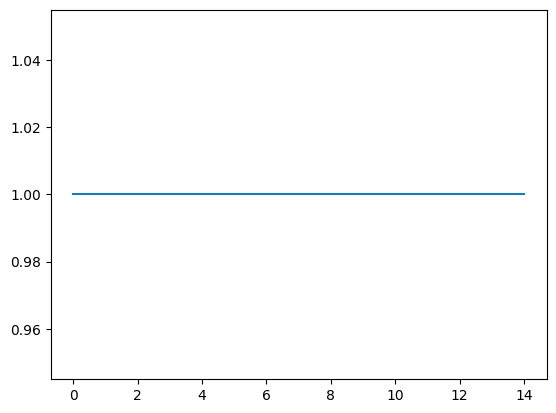

In [56]:
fig, ax = plt.subplots()

ax.plot(np.arange(n_epochs), accuracies)

In [47]:
count = 0
for batch, (inputs, outputs) in enumerate(train_loader):
        if count < 1:
            inputs, outputs = inputs.to(device), outputs.to(device)
            
            input0 = inputs[0]
            print(input0.size())
            
            # compute predictions
            prediction = model(input0)
            rounded_prediction = torch.round(prediction)
            print(rounded_prediction)
            output0 = outputs[0]
            print(output0)
        count += 1

torch.Size([1, 156])
tensor([[1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
         0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
         0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
         1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
         1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
         0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([[1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
         0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,

In [48]:
if rounded_prediction.equal(output0):
    print('correct')

correct


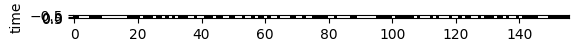

In [49]:
cpl.plot(output0.cpu())

In [50]:
rounded_prediction = rounded_prediction.detach()
rounded_prediction = rounded_prediction.cpu()

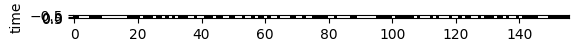

In [51]:
cpl.plot(rounded_prediction)